# Example clustering

This notebook shows some of `clustering` algorithms used in the [Siamese Networks](https://github.com/yui-mhcp/siamese_networks) project. These algorithms are really useful to identify clusters in the prediction of a `Siamese Network`. 

I have implemented 2 main algorithms : 
- `KMeans` : the classical KMeans algorithm implemented in `tensorflow`. It also supports a variant which tries to discover the best value of `k` by testing multiple values of `k` and finding an *elbow* in the scores. i.e. a `k` where the SSE score decreases but less than before. It also supports the `KMeans++` initialization.
- `KPropagation` : a funny algorithm I implemented to use the `similarity_matrix` produced by the `siamese_networks`. The idea is to assign a label to the 1st point and propagate the label to other points that are *close enough* to the cluster. If the point is too far from the cluster (mean similarity less than a threshold), it will be assigned to a new cluster.

Note that the `KPropagation` requires a `similarity_matrix`. If no matrix is given, it will create based on the formula : $ 1. - normalized\_distance\_matrix $ where *normalized_distance_matrix* is the distance matrix between each point divided by the maximum distance. 

Note that both implementation have a mechanism to remove *mini clusters* from less than `N` elements and reassign them to the nearest cluster (because both can decide to create a new cluster for 2 points just to have a better score even if it is not relevant). You can adjust this behaviour by modifying the `min_cluster_size` parameter. It is the reason why, even by specifying a fix `k` (`KMeans`), you can get less clusters (you can remove this behavior by setting `min_cluster_size` to 0).

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.datasets import make_blobs, make_moons

from utils import plot, plot_embedding, sample_df
from utils.embeddings import load_embedding, embeddings_to_np
from utils.distance import KPropagation, KMeans

def test_kmeans(x, y, plot = True):
    k_means = KMeans(x, k = list(range(2, 10)))
    acc, accs = k_means.evaluate(y)

    print("Best k = {}".format(k_means.k))
    print("Accuracy (mean : {:.2f}) : {}".format(acc * 100, accs))

    if plot: k_means.plot()
    return k_means.labels

def test_kpropagation(x, y, plot = True):
    k_prop = KPropagation(
        x, min_cluster_size = 0.1, threshold = 0.6, distance_metric = 'euclidian', debug = False
    )
    acc, accs = k_prop.evaluate(y)

    print("Best k = {}".format(k_prop.n_cluster))
    print("Accuracy (mean : {:.2f}) : {}".format(acc * 100, accs))

    if plot: k_prop.plot()
    return k_prop.labels

random_state = 10
directory = 'example_data'
filename = 'embeddings_{}_voxforge.csv'

## Test on blobs

Blobs are vectors grouped around a same center, quite perfect to test the variable `KMeans` and the `KPropagation` algorithms to see if they correcly detect well separable clusters.

The `KMeans` algorithm is highly influenced by its initialization, it is the reason why I implemented (like in `sklearn`) multiple initialization and keep the best one. Even with this behaviour, it suffers from a high variance especially when the feature size is high.

A contrario, the `KPropagation` tends to be better when the dimension are large enough (greater than 10) (at least when no similarity matrixis given). 

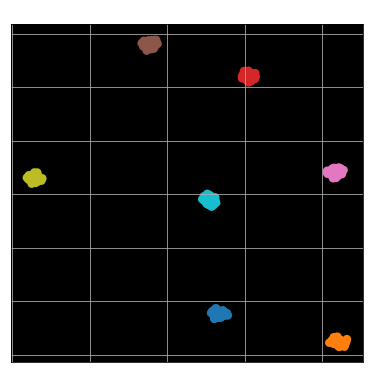

In [2]:
blobs_x, blobs_y = make_blobs(
    n_samples = 250, n_features = 128, centers = 7, cluster_std = 1., random_state = random_state
)
plot_embedding(blobs_x, blobs_y)

Best k = 8
Accuracy (mean : 93.06) : [1.0, 1.0, 1.0, 1.0, 1.0, 0.5142857142857142, 1.0]


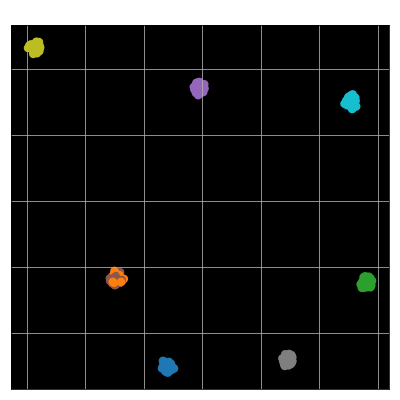

In [3]:
_ = test_kmeans(blobs_x, blobs_y)

Best k = 7
Accuracy (mean : 100.00) : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


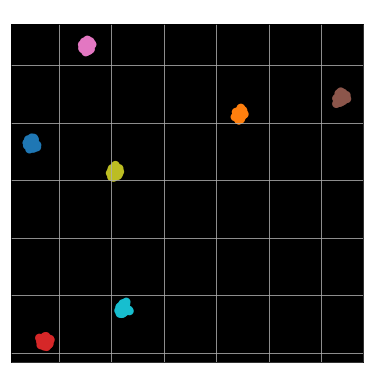

In [4]:
_ = test_kpropagation(blobs_x, blobs_y)

## Test with embeddings

This test is the same as before but with real `embeddings` produced by the `siamese_networks` on the `VoxForge` dataset

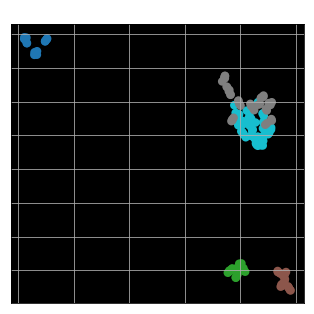

In [5]:
embeddings = load_embedding(directory, embedding_dim = 256, embedding_name = filename)

samples = sample_df(embeddings, n = 5, n_sample = 50)

x, y = embeddings_to_np(samples), samples['id'].values

plot_embedding(x, y)

Best k = 2
Accuracy (mean : 40.00) : [1.0, 0.0, 0.0, 1.0, 0.0]


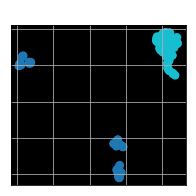

In [6]:
_ = test_kmeans(x, y)

Best k = 4
Accuracy (mean : 53.80) : [1.0, 0.9, 0.0, 0.55, 0.24]


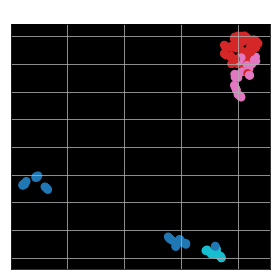

In [7]:
_ = test_kpropagation(x, y)

## Tests on moons

This test is harder because data are in 2-D (which is quite bad for the `KPropagation` as no similarity matrix is given) and the shape is quite strange. 

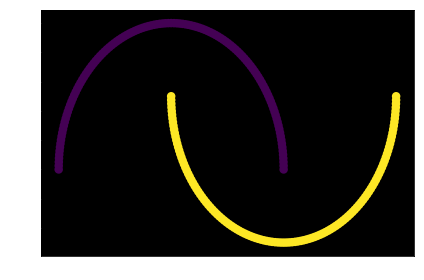

In [8]:
moons_x, moons_y = make_moons(
    n_samples = 250, random_state = random_state
)

plot(moons_x[:,0], moons_x[:,1], c = moons_y, plot_type = 'scatter')

Best k = 8
Accuracy (mean : 27.20) : [0.272, 0.272]


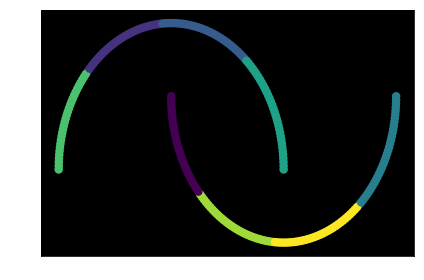

In [9]:
assignment = test_kmeans(moons_x, moons_y, False)

plot(moons_x[:,0], moons_x[:,1], c = assignment, plot_type = 'scatter')

Best k = 4
Accuracy (mean : 50.80) : [0.512, 0.504]


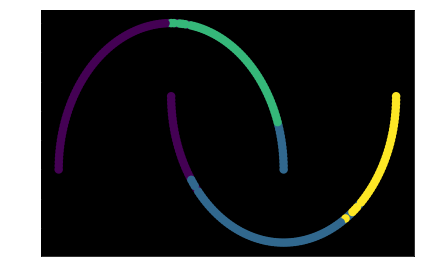

In [10]:
assignment = test_kpropagation(moons_x, moons_y, False)

plot(moons_x[:,0], moons_x[:,1], c = assignment, plot_type = 'scatter')